# Text Mining - Online Job Postings

#### Business Context:
The project seeks to understand the overall demand for labour in the Armenian online job market
from the 19,000 job postings from 2004 to 2015 posted on CareerCenter, an Armenian human
resource portal. Through text mining on this data, we will be able to understand the nature of the
ever-changing job market, as well as the overall demand for labour in the Armenia economy. The
data was originally scraped from a Yahoo! Mailing group.

#### Business Objectives:
Our main business objectives are to understand the dynamics of the labour market of Armenia using
the online job portal post as a proxy. A secondary objective is to implement advanced text analytics
as a proof of concept to create additional features such as enhanced search function that can add
additional value to the users of the job portal.

### Importing the necessary library.

In [1]:
import numpy as np              
import pandas as pd                  
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

### create UDFs

In [2]:
# Create Data audit Report for continuous variables
def continuous_summary(x):
    return pd.Series([x.count(), x.isna().sum(), x.isna().sum()*100/x.isna().count(), x.nunique(), 
                      x.sum(), x.mean(), x.median(), x.std(), 
                      x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.1), x.quantile(0.25), x.quantile(0.5), 
                      x.quantile(0.75), x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max()],
            index = ['N', 'NMISS', '% NMISS', 'UNIQUES', 'SUM', 'MEAN', 'MEDIAN', 'STD', 
                     'MIN', 'P1','P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [3]:
# Create Data audit Report for categorical variables
def categorical_summary(x):
    Mode = x.value_counts().sort_values(ascending = False).reset_index()[0:1]
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [5]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = False)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### Import the data

In [6]:
df = pd.read_csv('data job posts.csv')

In [7]:
df.head(2) 

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False


In [8]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             18973 non-null  object
 3   Company           18994 non-null  object
 4   AnnouncementCode  1208 non-null   object
 5   Term              7676 non-null   object
 6   Eligibility       4930 non-null   object
 7   Audience          640 non-null    object
 8   StartDate         9675 non-null   object
 9   Duration          10798 non-null  object
 10  Location          18969 non-null  object
 11  JobDescription    15109 non-null  object
 12  JobRequirment     16479 non-null  object
 13  RequiredQual      18517 non-null  object
 14  Salary            9622 non-null   object
 15  ApplicationP      18941 non-null  object
 16  OpeningDate       18295 non-null  object
 17  Deadline    

### Exploratory Data Analysis(EDA)

In [9]:
df.select_dtypes(include='number').apply(continuous_summary).T.round(1)

,N,NMISS,% NMISS,UNIQUES,SUM,MEAN,MEDIAN,STD,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Year,19001.0,0.0,0.0,12.0,38197230.0,2010.3,2011.0,3.3,2004.0,2004.0,2005.0,2005.0,2008.0,2011.0,2013.0,2015.0,2015.0,2015.0,2015.0
Month,19001.0,0.0,0.0,12.0,123390.0,6.5,7.0,3.4,1.0,1.0,1.0,2.0,3.0,7.0,9.0,11.0,12.0,12.0,12.0


In [10]:
df.select_dtypes(include=['object', 'bool']).apply(categorical_summary).T

,N,NMISS,MODE,FREQ,PERCENT
jobpost,19001,0,Career Center NGO\nTITLE: English Language Co...,11,0.06
date,19001,0,"May 6, 2014",24,0.13
Title,18973,28,Accountant,328,1.73
Company,18994,7,ArmenTel CJSC,353,1.86
AnnouncementCode,1208,17793,IOS - 001,9,0.75
Term,7676,11325,Full time,5348,69.67
Eligibility,4930,14071,All qualified candidates,1223,24.81
Audience,640,18361,All interested candidates,105,16.41
StartDate,9675,9326,ASAP,4754,49.14
Duration,10798,8203,Long term,3458,32.02


In [11]:
df.columns

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')

#### Data Dictionary
* Job post = The full text of Job post.<br>
* Title = Title of the job.<br>
* company = Company of the Job.<br>
* Job Description = Job Description.<br>
* Job Requirement = Job Requirements.<br>
* Required Qual = Required Qualifications.<br>
* About C = About the Company.<br>
* Year = Year of the announcement (Derived from the field Date)<br>
* Month = Month of the announcement (Derived from the field Date)<br>
* IT = True if the job is an IT Job.<br>

In [12]:
# Subsetting Necessary Columns 
data = df[['jobpost','Title','Company','JobDescription','JobRequirment','RequiredQual','AboutC','Year','Month','IT']]

In [13]:
data.head(2)

,jobpost,Title,Company,JobDescription,JobRequirment,RequiredQual,AboutC,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,Chief Financial Officer,AMERIA Investment Consulting Company,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\nindividu...",NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,- Bachelor's Degree; Master's is preferred;\n-...,The International Research & Exchanges Board (...,2004,1,False


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   jobpost         19001 non-null  object
 1   Title           18973 non-null  object
 2   Company         18994 non-null  object
 3   JobDescription  15109 non-null  object
 4   JobRequirment   16479 non-null  object
 5   RequiredQual    18517 non-null  object
 6   AboutC          12470 non-null  object
 7   Year            19001 non-null  int64 
 8   Month           19001 non-null  int64 
 9   IT              19001 non-null  bool  
dtypes: bool(1), int64(2), object(7)
memory usage: 1.3+ MB


In [15]:
# getting the missing values
data.isna().sum()

jobpost              0
Title               28
Company              7
JobDescription    3892
JobRequirment     2522
RequiredQual       484
AboutC            6531
Year                 0
Month                0
IT                   0
dtype: int64

In [16]:
# treating  missing value
cat_col = data.select_dtypes('object').columns
data.loc[:,cat_col] = data[cat_col].apply(lambda x: x.fillna(x.mode()[0]))

In [17]:
data.isna().sum()

jobpost           0
Title             0
Company           0
JobDescription    0
JobRequirment     0
RequiredQual      0
AboutC            0
Year              0
Month             0
IT                0
dtype: int64

### Job Nature and Company Profiles: 
What are the types of jobs that are in demand in Armenia?
How are the job natures changing over time? 

In [18]:
# Top 10 Job role
data[['Title','jobpost']].groupby('Title').count().nlargest(10,'jobpost').reset_index()

,Title,jobpost
0,Accountant,356
1,Chief Accountant,219
2,Medical Representative,216
3,Sales Manager,166
4,Administrative Assistant,155
5,Lawyer,151
6,Software Developer,134
7,Project Manager,117
8,English Language Courses,109
9,Web Developer,101


In [19]:
# top company job postings
data.groupby('Company')['jobpost'].count().nlargest(10).reset_index()

,Company,jobpost
0,ArmenTel CJSC,360
1,World Vision Armenia,239
2,Mentor Graphics Development Services CJSC,236
3,Career Center NGO,229
4,Orange Armenia,203
5,Ameriabank CJSC,196
6,Converse Bank CJSC,161
7,SAS Group LLC,150
8,UNDP Armenia Office,132
9,Central Bank of Armenia,126


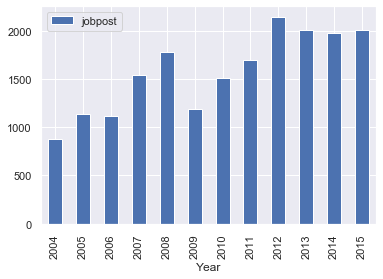

In [20]:
data[['Year','jobpost']].groupby(['Year']).count().plot(kind='bar')
plt.show()

-   **Year 2012 showing the maximum job postings**

-    **Big fall in year 2009, likely due to the crisis in between 2008-2009**

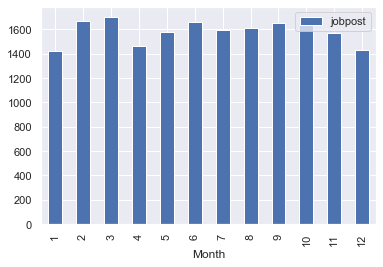

In [21]:
data[['Month','jobpost']].groupby(['Month']).count().plot(kind='bar')
plt.show()

-   **Month March showing the maximum job postings**

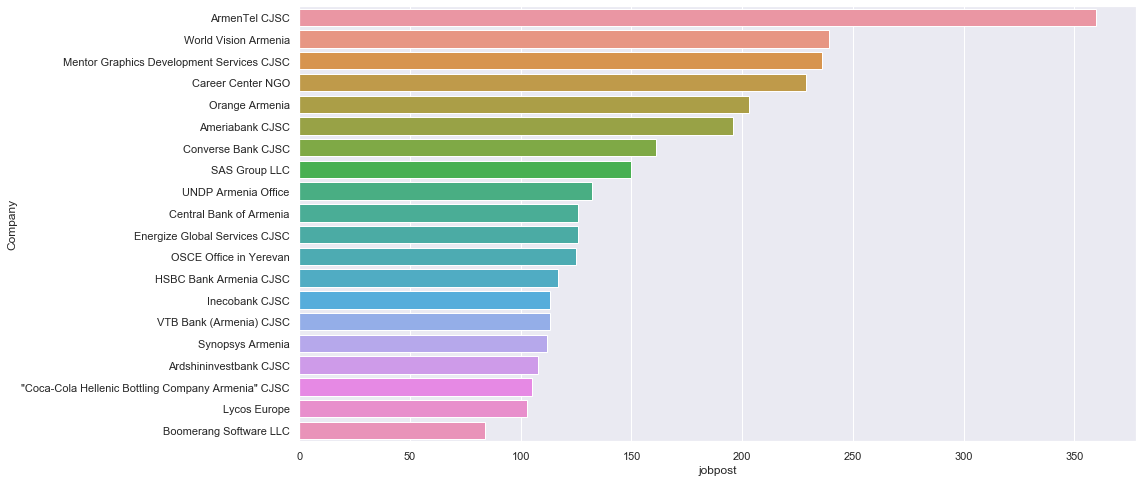

In [22]:
company_jobpost = data[['Company','jobpost']].groupby('Company').count().nlargest(20,'jobpost').reset_index()
plt.figure(figsize=(15, 8))
sns.barplot(x=company_jobpost['jobpost'], y=company_jobpost['Company'])
plt.show()

-   **Company 'Armen Tel CJSC' showing the maximum job postings**

In [23]:
# Numbers of post for top jobs with years
ct = pd.crosstab(index = data.Year,
                 columns = data.Title,
                 values = data.jobpost,
                 aggfunc = 'count')

top_title = data[['Title','jobpost']].groupby('Title').count().nlargest(10,'jobpost').index.tolist()
ct = ct[top_title].fillna(0)
ct.T

Year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Title,,,,,,,,,,,,
Accountant,17.0,27.0,33.0,42.0,41.0,21.0,27.0,25.0,33.0,29.0,34.0,27.0
Chief Accountant,13.0,16.0,20.0,28.0,27.0,15.0,13.0,26.0,15.0,17.0,12.0,17.0
Medical Representative,0.0,7.0,14.0,12.0,17.0,16.0,33.0,24.0,28.0,33.0,16.0,16.0
Sales Manager,3.0,3.0,8.0,9.0,24.0,13.0,14.0,12.0,27.0,19.0,25.0,9.0
Administrative Assistant,14.0,14.0,22.0,18.0,13.0,10.0,10.0,5.0,12.0,13.0,9.0,15.0
Lawyer,5.0,4.0,9.0,9.0,16.0,17.0,13.0,11.0,24.0,17.0,11.0,15.0
Software Developer,4.0,13.0,13.0,17.0,10.0,7.0,3.0,9.0,18.0,9.0,18.0,13.0
Project Manager,5.0,6.0,4.0,6.0,12.0,9.0,10.0,12.0,11.0,9.0,18.0,15.0
English Language Courses,0.0,16.0,0.0,4.0,1.0,11.0,37.0,3.0,5.0,11.0,6.0,15.0


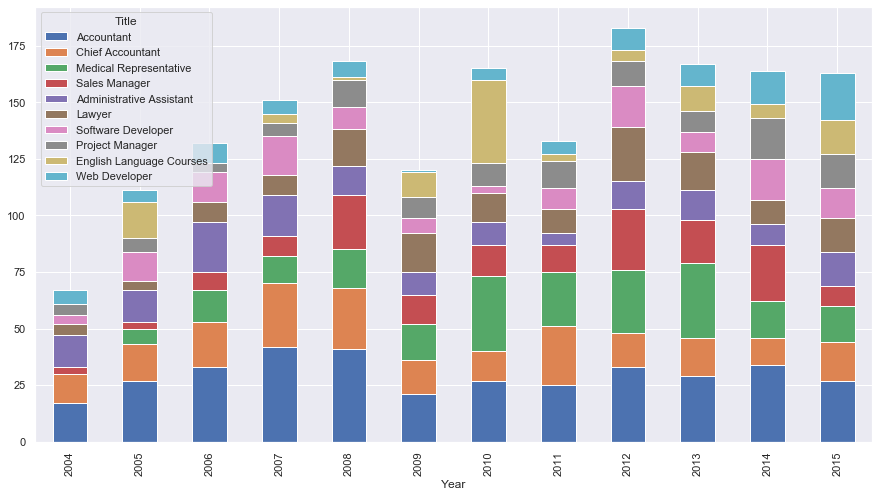

In [24]:
ct.plot(kind='bar',stacked=True,figsize=(15,8),mark_right=True)
plt.show()

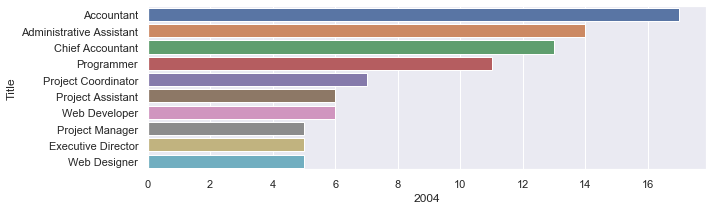

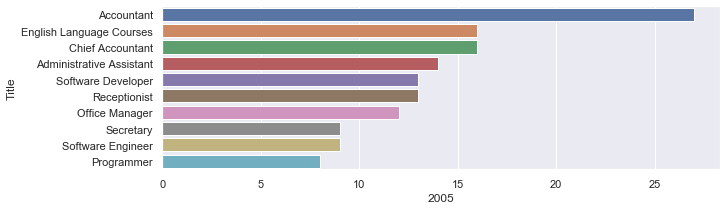

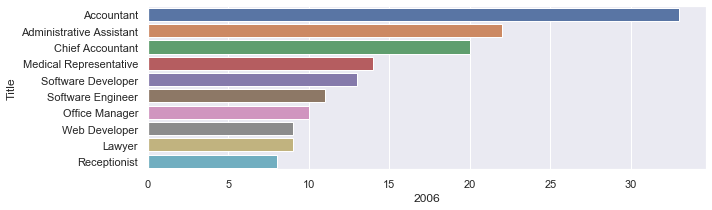

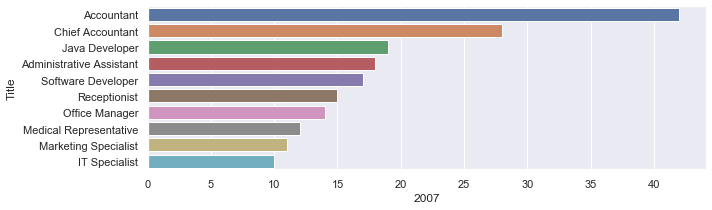

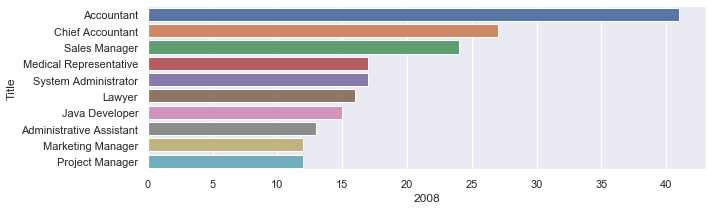

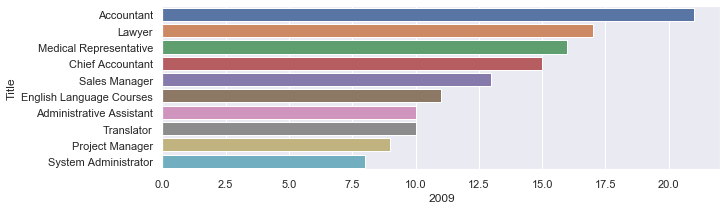

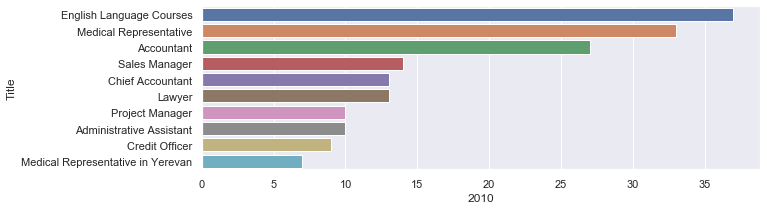

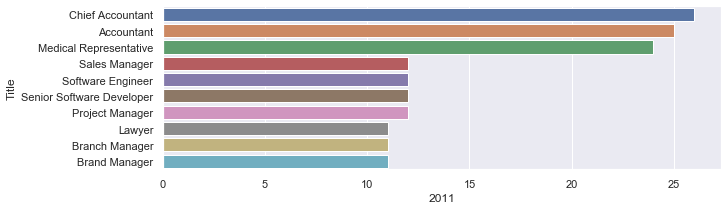

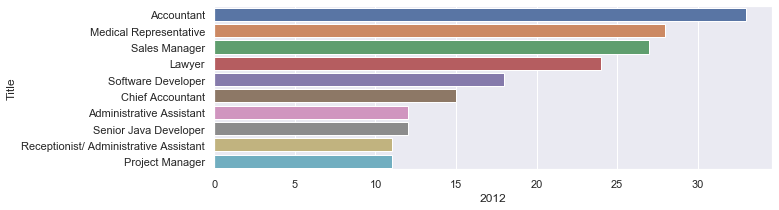

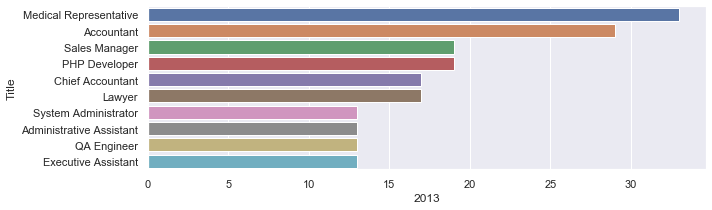

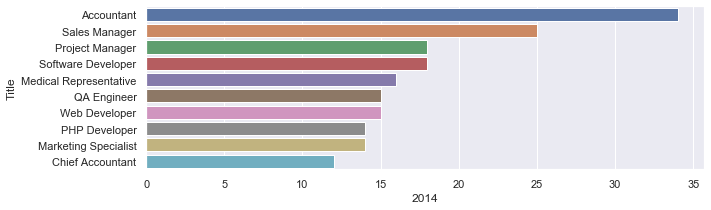

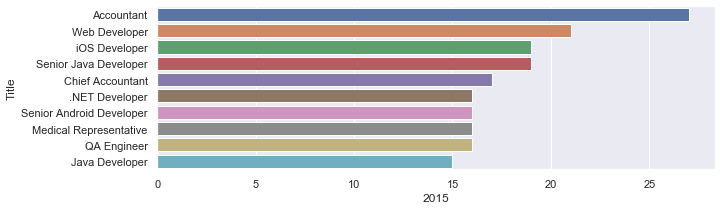

In [25]:
# year wise change in number of post for top jobs
for year in data.Year.unique():
    group_year = data[data.Year == year].groupby('Title').jobpost.count().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,3))
    sns.barplot(y=group_year.index, x=group_year)
    plt.xlabel(year)
    plt.show()

### Analysis
- From 2004 to 2009 , there is high demand for the job posting in Accountant.
- In 2010 , the maximum job postings changes to English Language coures
- In 2011, there is high demand for the Cheif Accountant
- In 2012, the job postings for Accountant is maximum.
- In 2013, Medical Representatives have maximum job postings.
- In 2014 and 2015, highest job postings is done in Accountant.

### Desired Characteristics and Skill-Sets: 
What are the desired characteristics and skill-set of the candidates based on the job description dataset? 

How these are desired characteristics changing over time? 

In [26]:
data_old = data.copy()

In [27]:
data.head(2)

,jobpost,Title,Company,JobDescription,JobRequirment,RequiredQual,AboutC,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,Chief Financial Officer,AMERIA Investment Consulting Company,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\nindividu...",Mentor Graphics Development Services CJSC is a...,2004,1,False
1,International Research & Exchanges Board (IREX...,Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),The incumbent will work under the direct super...,- Participate in application design;\n- Provid...,- Bachelor's Degree; Master's is preferred;\n-...,The International Research & Exchanges Board (...,2004,1,False


## Cleaning Text

In [28]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer

ps = PorterStemmer()
wnl = WordNetLemmatizer()
all_stopwords = stopwords.words('english')

for col in data.columns.difference(['Year','Month','IT']):
    data[col] = data[col].astype('str')
    for i in range(0, data.shape[0]):
        review = re.sub('[^a-zA-Z]', ' ', data[col][i])
        review = review.lower()
        review = review.split()
        review = [wnl.lemmatize(word, pos='v') for word in review if not word in set(all_stopwords)]
        #review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
        review = ' '.join(review)
        data.loc[i,col] = review

In [29]:
data.head(2)

,jobpost,Title,Company,JobDescription,JobRequirment,RequiredQual,AboutC,Year,Month,IT
0,ameria investment consult company job title ch...,chief financial officer,ameria investment consult company,ameria investment consult company seek chief f...,supervise financial management administrative ...,perform job successfully individual must able ...,mentor graphics development service cjsc subsi...,2004,1,False
1,international research exchange board irex tit...,full time community connections intern pay int...,international research exchange board irex,incumbent work direct supervision company pres...,participate application design provide necessa...,bachelor degree master prefer excellent skills...,international research exchange board irex us ...,2004,1,False


## Most frequent words (key positive/negative words)

In [30]:
word_count = {}
for tokens in data['RequiredQual']:
    tokens = nltk.wordpunct_tokenize(tokens)
    for token in tokens:
        if token in word_count:
            word_count[token] += 1
        else:
            word_count[token] = 1

In [31]:
# Converting word_count into the dataframe
word_freq = pd.DataFrame(word_count.items(), columns=['words','count'])
word_freq = word_freq.sort_values('count', ascending=False).reset_index(drop=True)
word_freq.head()

,words,count
0,knowledge,37399
1,experience,33620
2,skills,32675
3,work,26107
4,ability,23313


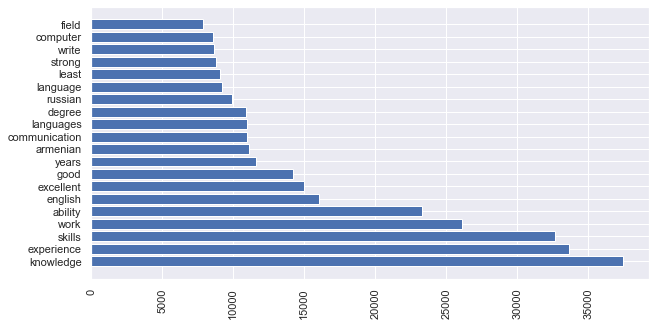

In [32]:
plt.figure(figsize=(10,5))
plt.barh(word_freq['words'].head(20), word_freq['count'].head(20))
plt.xticks(rotation = 90)
plt.show()

### Word Cloud of the Title columns

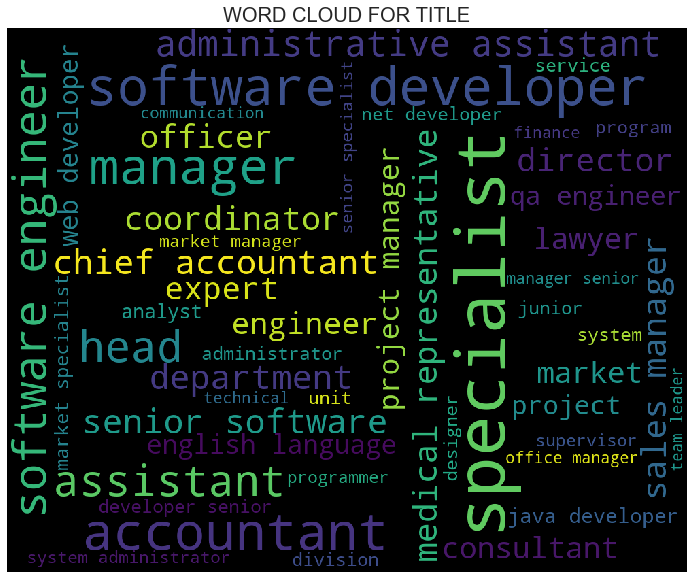

In [33]:
#pip install wordcloud
from wordcloud import WordCloud ,STOPWORDS

wordcloud = WordCloud(background_color='black',
                      stopwords=[],
                      max_words=50,
                      max_font_size=100, 
                      width=1000, height=800).generate(' '.join(data['Title'].astype('str')))

plt.figure(figsize = (20,10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD FOR TITLE",fontsize=20)
plt.axis('off')
plt.show()

### Word Cloud of the RequiredQual columns

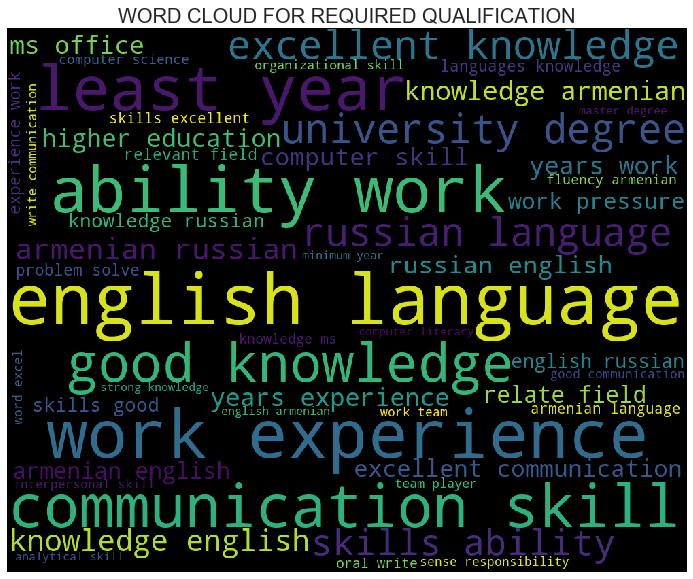

In [34]:
#pip install wordcloud
from wordcloud import WordCloud ,STOPWORDS

wordcloud = WordCloud(background_color='black',
                      stopwords=[],
                      max_words=50,
                      max_font_size=200, 
                      width=1000, height=800).generate(' '.join(data['RequiredQual'].astype('str')))

plt.figure(figsize = (20,10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD FOR REQUIRED QUALIFICATION",fontsize=20)
plt.axis('off')
plt.show()

### IT  Job  Classification:  
Build  a  classifier  that  can  tell  us  from  the  job  description  and company 
description whether a job is IT or not, so that this column can be automatically populated for new 
job postings. After doing so, understand what important factors are which drives this classification. 

In [35]:
data['IT'] = data['IT'].astype('int')

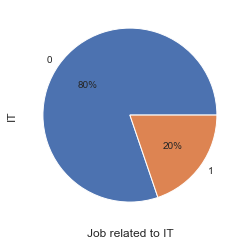

In [36]:
data['IT'].value_counts().plot.pie(autopct='%1.0f%%',fontsize=10)
plt.xlabel('Job related to IT')
plt.show()

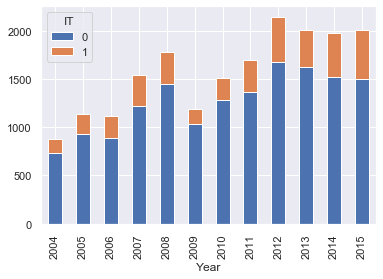

In [37]:
pd.crosstab(index=data['Year'],columns=data['IT'],values=data['IT'],aggfunc='count').plot(kind='bar',stacked=True)
plt.show()

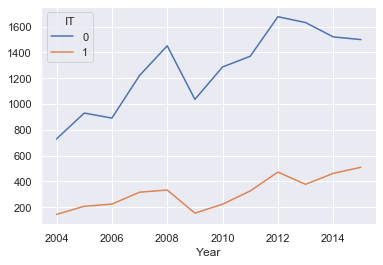

In [38]:
pd.crosstab(index=data['Year'],columns=data['IT'],values=data['IT'],aggfunc='count').plot(kind='line',stacked=False)
plt.show()

#### Calculating Sentiment analysis using Textblob module

In [39]:
from textblob import TextBlob
data['polarity'] = data['JobDescription'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [40]:
data['Sentiment']  = np.where(data.polarity == 0,'Neutral',np.where(data.polarity<0,'Negative','Positive'))

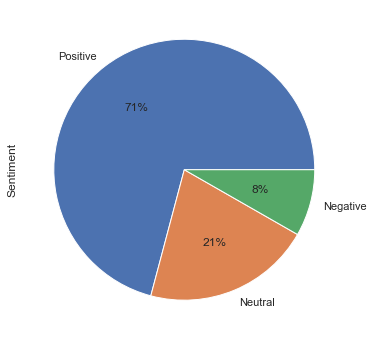

In [41]:
plt.figure(figsize=(12,6))
data['Sentiment'].value_counts().plot(kind='pie', autopct= '%1.0f%%')
plt.show()

In [42]:
pd.crosstab(index=data.IT,
    columns=data.Sentiment,
    values=data.Sentiment,
    aggfunc='count')

Sentiment,Negative,Neutral,Positive
IT,,,
0,1039,3029,11174
1,532,935,2292


# model

In [43]:
#data.to_csv('data_final.csv',index=False)
#data = pd.read_csv('data_final.csv')

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

from sklearn.tree import ExtraTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [45]:
# Different models
models = []
models.append(('LR', LogisticRegression()))
models.append(('RFC', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ADABC', AdaBoostClassifier()))
models.append(('ETC', ExtraTreeClassifier()))
models.append(('XGBC', XGBClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('SVCL', svm.SVC(kernel='linear')))

#### TfidfVectorizer of clean text and Train Test split

In [46]:
data.head(2)

,jobpost,Title,Company,JobDescription,JobRequirment,RequiredQual,AboutC,Year,Month,IT,polarity,Sentiment
0,ameria investment consult company job title ch...,chief financial officer,ameria investment consult company,ameria investment consult company seek chief f...,supervise financial management administrative ...,perform job successfully individual must able ...,mentor graphics development service cjsc subsi...,2004,1,0,0.01,Positive
1,international research exchange board irex tit...,full time community connections intern pay int...,international research exchange board irex,incumbent work direct supervision company pres...,participate application design provide necessa...,bachelor degree master prefer excellent skills...,international research exchange board irex us ...,2004,1,0,0.15,Positive


In [47]:
X = data['RequiredQual']
y = data['IT']

In [48]:
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [49]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vector = CountVectorizer()
tfidf_vector = TfidfVectorizer()

train_x = count_vector.fit_transform(train_x)
test_x = count_vector.transform(test_x)

In [50]:
pd.DataFrame(train_x.toarray(), columns=count_vector.get_feature_names()).head()

,aa,aaa,aaaa,aability,aac,aadvanced,aarhus,aas,abap,abaqus,...,zabbix,zend,zendframework,zero,zf,zigbee,zone,zoology,zte,zyhel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# evaluate each model in turn
names = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring='roc_auc', n_jobs=-1)
    names.append(name)
    results.append(cv_results)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.950816 (0.005492)
RFC: 0.963425 (0.001841)
KNN: 0.917951 (0.011941)
CART: 0.867262 (0.007278)
ADABC: 0.932254 (0.004694)
ETC: 0.850706 (0.011167)
XGBC: 0.959089 (0.006215)
GBC: 0.944273 (0.004558)
SVCL: 0.934332 (0.008322)


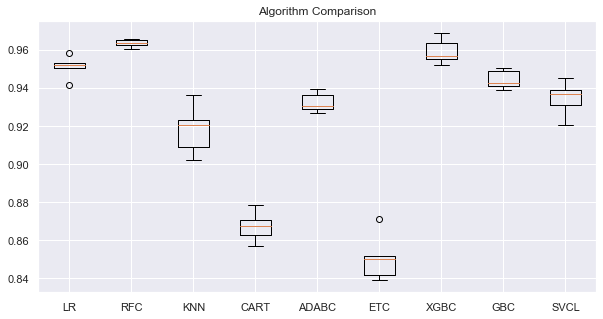

In [52]:
# Compare Algorithms
plt.figure(figsize=(10,5))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [53]:
models_df = pd.DataFrame({'Model': names, 'Score': [round(r.mean()*100,4) for r in results]})
models_df.sort_values(by='Score', ascending=False, inplace=True)
models_df

,Model,Score
1,RFC,96.3425
6,XGBC,95.9089
0,LR,95.0816
7,GBC,94.4273
8,SVCL,93.4332
4,ADABC,93.2254
2,KNN,91.7951
3,CART,86.7262
5,ETC,85.0706


### Supervised Learning 

In [54]:
param = {'n_estimators': [100],
         'max_depth': [50,100,150],
         'min_samples_split':[3,4,5]
        }
gscv_rf = GridSearchCV(estimator = RandomForestClassifier(random_state=42), 
                     param_grid=param,
                     scoring = 'roc_auc',
                     cv = 5,
                     n_jobs = -1,
                     verbose=5).fit(train_x, train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 12.8min finished


In [55]:
gscv_rf.best_estimator_

RandomForestClassifier(max_depth=150, min_samples_split=3, random_state=42)

In [56]:
gscv_rf.best_score_

0.9636719561219937

In [57]:
rf = gscv_rf.best_estimator_
rf.fit(train_x, train_y)

# Making prediction on train and test data
rf_train_pred = rf.predict(train_x)
rf_test_pred = rf.predict(test_x)

In [58]:
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, rf_train_pred))
print("AUC      : ", metrics.roc_auc_score(train_y, rf_train_pred))
print("Log Loss : ", metrics.log_loss(train_y, rf.predict_proba(train_x)))

print("Test Dataset")
print("Accuracy : ", metrics.accuracy_score(test_y, rf_test_pred))
print("AUC      : ", metrics.roc_auc_score(test_y, rf_test_pred))
print("Log Loss : ", metrics.log_loss(test_y, rf.predict_proba(test_x)))

Train Dataset
Accuracy :  0.9928571428571429
AUC      :  0.9858886795311771
Log Loss :  0.05984282777586847
Test Dataset
Accuracy :  0.9461497982810033
AUC      :  0.8959959645905223
Log Loss :  0.1704432069982915


In [59]:
# Getting classification metrics scores
print(metrics.classification_report(test_y, rf_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4619
           1       0.89      0.82      0.85      1082

    accuracy                           0.95      5701
   macro avg       0.92      0.90      0.91      5701
weighted avg       0.95      0.95      0.95      5701



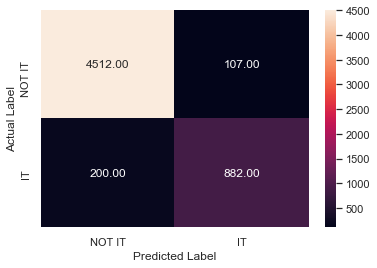

In [60]:
confusion_matrix = metrics.confusion_matrix(test_y, rf_test_pred, labels = [0,1])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['NOT IT','IT'], 
            yticklabels = ['NOT IT','IT'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

### Supervised Learning 

In [61]:
gscv_xgb = GridSearchCV(estimator = XGBClassifier(random_state=42), 
                     param_grid={},
                     scoring = 'roc_auc',
                     cv = 10,
                     n_jobs = -1,
                     verbose=5).fit(train_x, train_y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.7min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.5min finished


In [62]:
gscv_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
gscv_xgb.best_score_

0.961531584432502

In [64]:
xgb = gscv_xgb.best_estimator_
xgb.fit(train_x, train_y)

# Making prediction on train and test data
xgb_train_pred = xgb.predict(train_x)
xgb_test_pred = xgb.predict(test_x)

In [65]:
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, xgb_train_pred))
print("AUC      : ", metrics.roc_auc_score(train_y, xgb_train_pred))
print("Log Loss : ", metrics.log_loss(train_y, xgb.predict_proba(train_x)))

print("Test Dataset")
print("Accuracy : ", metrics.accuracy_score(test_y, xgb_test_pred))
print("AUC      : ", metrics.roc_auc_score(test_y, xgb_test_pred))
print("Log Loss : ", metrics.log_loss(test_y, xgb.predict_proba(test_x)))

Train Dataset
Accuracy :  0.9738345864661654
AUC      :  0.9460388439023579
Log Loss :  0.08767104153600958
Test Dataset
Accuracy :  0.9410629714085248
AUC      :  0.8925028982995975
Log Loss :  0.166203509022447


In [66]:
# Getting classification metrics scores
print(metrics.classification_report(test_y, xgb_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4619
           1       0.87      0.81      0.84      1082

    accuracy                           0.94      5701
   macro avg       0.91      0.89      0.90      5701
weighted avg       0.94      0.94      0.94      5701



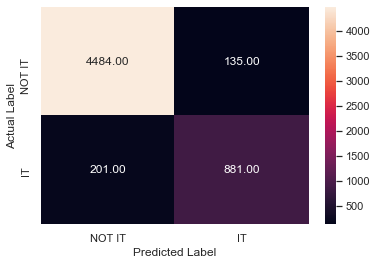

In [67]:
confusion_matrix = metrics.confusion_matrix(test_y, xgb_test_pred, labels = [0,1])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['NOT IT','IT'], 
            yticklabels = ['NOT IT','IT'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

### Unsupervised Learning 

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.9, 
                             ngram_range=(1, 3), 
                             stop_words='english')

X_train = vectorizer.fit_transform(data['RequiredQual'])
vocab = vectorizer.get_feature_names()

In [69]:
vocab[:10]

['ability',
 'ability work',
 'ability work pressure',
 'account',
 'advance',
 'analytical',
 'armenian',
 'armenian english',
 'armenian russian',
 'armenian russian english']

In [70]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score,pairwise_distances

In [71]:
svd = TruncatedSVD(90)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X_train)

In [72]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 98%


In [73]:
# Calculating Silhouette Score for K = 3 to 20
k_range = range(3,21)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_lsa)
    scores.append(metrics.silhouette_score(X_lsa, km.labels_))

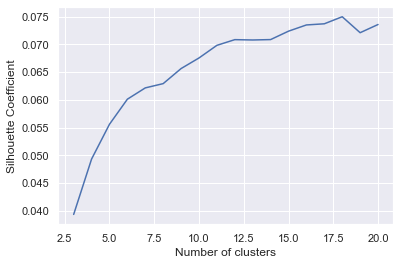

In [74]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

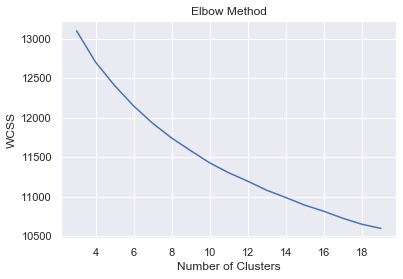

In [75]:
# Pseudo F-Score(Elbow Method)
wcss = []
for i in range(3,20):
    km = KMeans(n_clusters = i, random_state = 1)
    km.fit(X_lsa)
    wcss.append(km.inertia_)
plt.plot(range(3,20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [76]:
model = KMeans(n_clusters=6, 
               init='k-means++', 
               max_iter=100, n_init=1,random_state=5)

In [77]:
res = model.fit(X_train)
res

KMeans(max_iter=100, n_clusters=6, n_init=1, random_state=5)

In [78]:
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab) 

In [79]:
cluster_centers = np.array(res.cluster_centers_)

In [45]:
res.cluster_centers_[0].argsort()

array([ 10,   9,  82,  54,  45,  81,  68,  32,  11,   8,   3,  26,  36,
        78,  13,  48,  18,  42, 103,  51,  44,  55,  79,  20,  99,  60,
        29,  56, 105,  50,  62,  22,   7,  12,  37,  41,  23,  73,  67,
        72,  43, 107,  61,  94,  88,  92,  31,  49,  77, 108,  27,  83,
       109,  39,  76,   4,  95,  40,  63,   6,   2,  87,  14,  84,  98,
        97,  89,  74,  59, 102,  96,  58,  80,  69,  53,  28,  17,  65,
        46,  25,  16,  33,  35, 101,  75,  64,  24,  52,  21,  66,  19,
       106,  57,  86,  15,  93,  38,   5, 104,   1,  91,  30,  34, 100,
        47,   0,  90,  71,  70,  85], dtype=int64)

In [80]:
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]

In [81]:
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
    print(words)
    print('\n')

{'ability', 'design', 'development', 'software', 'experience', 'program', 'knowledge', 'work', 'years', 'skills'}


{'skills good', 'internet', 'software', 'communication', 'experience', 'knowledge', 'ability', 'self', 'communication skills', 'task', 'basic', 'design', 'excellent communication skills', 'development', 'program', 'work', 'years', 'learn', 'skills'}


{'armenian', 'education', 'skills good', 'internet', 'software', 'communication', 'experience', 'knowledge', 'ability', 'higher education', 'languages', 'russian', 'self', 'communication skills', 'higher', 'task', 'basic', 'account', 'design', 'excellent communication skills', 'development', 'program', 'work', 'years', 'learn', 'skills', 'bank'}


{'armenian', 'education', 'skills good', 'internet', 'software', 'communication', 'experience', 'management', 'knowledge', 'ability', 'higher education', 'languages', 'russian', 'self', 'communication skills', 'higher', 'task', 'basic', 'account', 'design', 'excellent communication

In [82]:
words = list(words)

In [83]:
train_set = X_train[:,[np.argwhere(vocab==i)[0][0] for i in words]]

In [84]:
data['cluster'] = model.labels_
data.groupby('cluster').RequiredQual.count()

cluster
0    2704
1     620
2    4355
3    4435
4    2879
5    4008
Name: RequiredQual, dtype: int64

In [85]:
data.head(2)

,jobpost,Title,Company,JobDescription,JobRequirment,RequiredQual,AboutC,Year,Month,IT,polarity,Sentiment,cluster
0,ameria investment consult company job title ch...,chief financial officer,ameria investment consult company,ameria investment consult company seek chief f...,supervise financial management administrative ...,perform job successfully individual must able ...,mentor graphics development service cjsc subsi...,2004,1,0,0.01,Positive,3
1,international research exchange board irex tit...,full time community connections intern pay int...,international research exchange board irex,incumbent work direct supervision company pres...,participate application design provide necessa...,bachelor degree master prefer excellent skills...,international research exchange board irex us ...,2004,1,0,0.15,Positive,5


# Topic Modelling

In [86]:
# train a LDA Model
from sklearn import decomposition
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20, n_jobs=-1)
X_topics = lda_model.fit_transform(X_train)
topic_word = lda_model.components_ 
vocab = vectorizer.get_feature_names()

In [88]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['english russian russian languages skills university degree university languages russian armenian degree armenian english',
 'experience project professional relevant management international years field relevant field years experience',
 'russian english russian english languages english languages armenian russian english knowledge armenian russian russian languages skills armenian',
 'knowledge russian higher relate field higher education english language responsibility economics professional armenian english level',
 'knowledge english language language knowledge english language knowledge english experience english prefer year good knowledge',
 'communication skills excellent communication skills skills excellent communication communication knowledge russian self learn task basic',
 'bank finance account knowledge armenian understand economics english language internet prefer good knowledge',
 'armenian russian languages russian languages armenian russian knowledge knowledge engli